Summary Statistics:
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      240.559452     167.187516     115.358961     236.589496   
std       331.131327     261.710501     158.691074     326.894859   
min       -12.900000      -7.800000     -12.600000       0.000000   
25%        -2.000000      -0.500000      -2.100000       0.000000   
50%         1.800000      -0.100000       1.600000       4.500000   
75%       483.400000     314.200000     216.300000     463.700000   
max      1413.000000     952.300000     759.200000    1342.300000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      228.883576      28.179683      54.487969       2.121113   
std       316.536515       5.924297      28.073069       1.603466   
min         0.000000      11.000000       2.100000       0.000000   
25%         0

C:\Users\bekel\AppData\Local\Temp\ipykernel_15624\118519379.py:31: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\bekel\AppData\Local\Temp\ipykernel_15624\118519379.py:31: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=


Cleaned data exported to ../data/benin_clean.csv


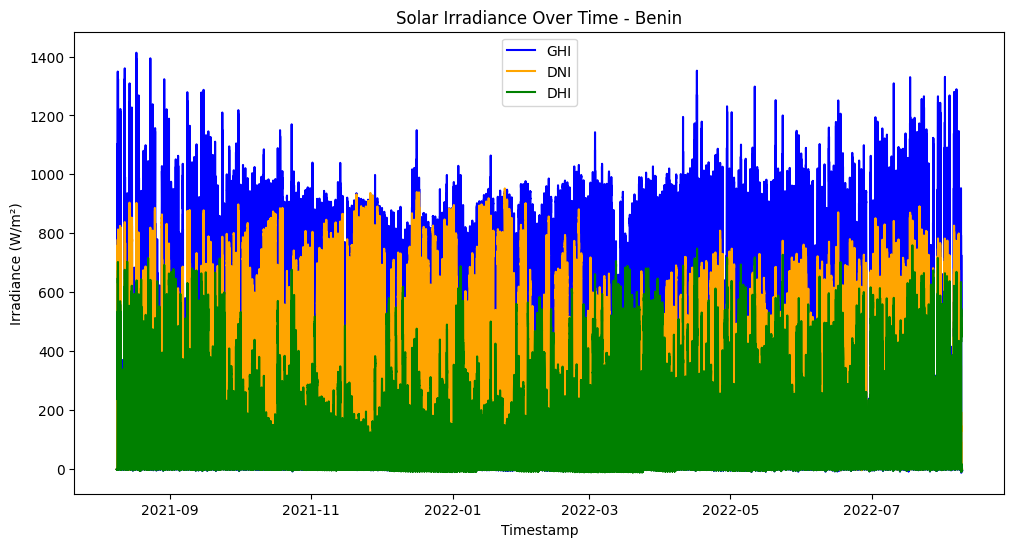


Cleaning Impact:
                ModA        ModB
Cleaning                        
0         236.524253  228.816071
1         307.229278  301.972165


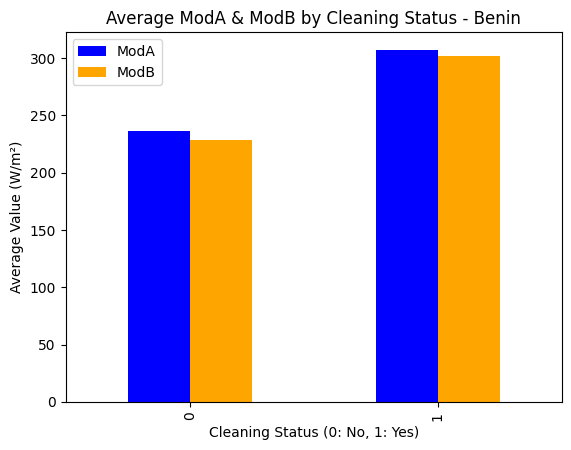

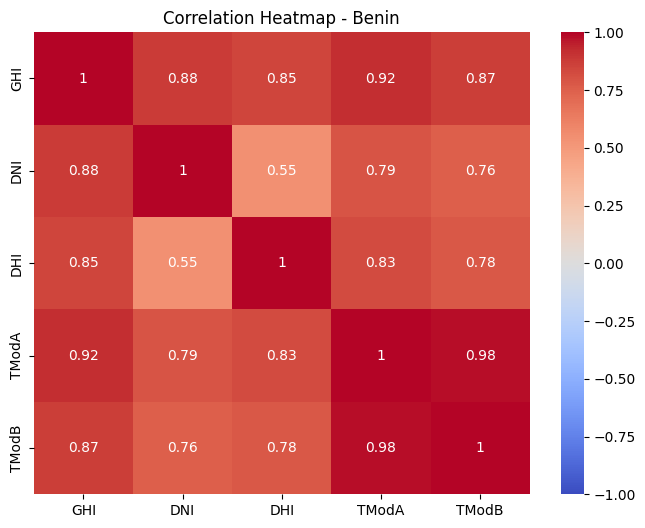

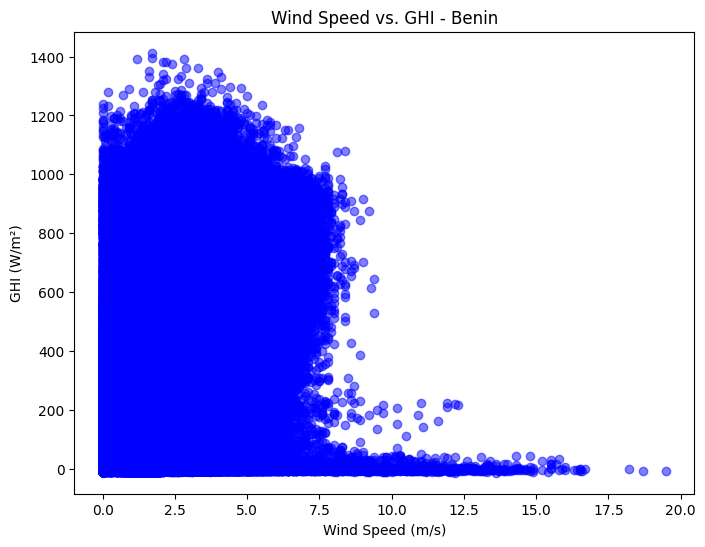

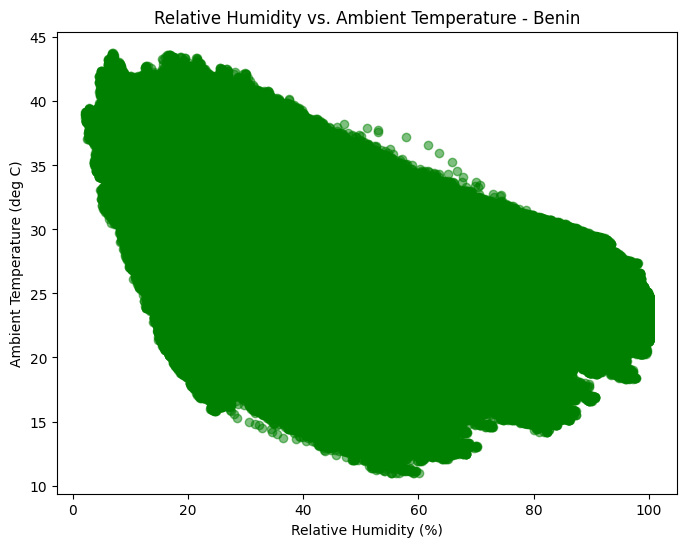

C:\Users\bekel\AppData\Local\Temp\ipykernel_15624\118519379.py:89: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [12]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import plotly.graph_objects as go
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Load data
try:
    df = pd.read_csv('../data/benin-malanville.csv')
except FileNotFoundError:
    print("Error: '../data/benin-malanville.csv' not found. Please ensure the file exists.")
    raise

# Summary Statistics
print('Summary Statistics:')
print(df.describe())
print('\nMissing Values:')
missing = df.isna().sum()
print(missing[missing > 0])
missing_pct = (missing / len(df)) * 100
print('\nColumns with >5% missing:')
print(missing_pct[missing_pct > 5])

# Outlier Detection
key_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = df[key_cols].apply(zscore, nan_policy='omit')
outliers = z_scores.apply(lambda x: (x.abs() > 3).sum())
print('\nOutliers (|Z|>3):')
print(outliers)

# Cleaning: Impute missing values with median
for col in key_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Export cleaned data
df.to_csv('../data/benin_clean.csv', index=False)
print('\nCleaned data exported to ../data/benin_clean.csv')

# Time Series Analysis
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'], df['GHI'], label='GHI', color='blue')
plt.plot(df['Timestamp'], df['DNI'], label='DNI', color='orange')
plt.plot(df['Timestamp'], df['DHI'], label='DHI', color='green')
plt.xlabel('Timestamp')
plt.ylabel('Irradiance (W/m²)')
plt.title('Solar Irradiance Over Time - Benin')
plt.legend()
plt.show()
plt.close()

# Cleaning Impact
cleaning_impact = df.groupby('Cleaning')[['ModA', 'ModB']].mean()
print('\nCleaning Impact:')
print(cleaning_impact)
cleaning_impact.plot(kind='bar', title='Average ModA & ModB by Cleaning Status - Benin', color=['blue', 'orange'])
plt.xlabel('Cleaning Status (0: No, 1: Yes)')
plt.ylabel('Average Value (W/m²)')
plt.show()
plt.close()

# Correlation Heatmap
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
corr = df[corr_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap - Benin')
plt.show()
plt.close()

# Scatter Plots
plt.figure(figsize=(8, 6))
plt.scatter(df['WS'], df['GHI'], alpha=0.5, color='blue')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('GHI (W/m²)')
plt.title('Wind Speed vs. GHI - Benin')
plt.show()
plt.close()

plt.figure(figsize=(8, 6))
plt.scatter(df['RH'], df['Tamb'], alpha=0.5, color='green')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Ambient Temperature (deg C)')
plt.title('Relative Humidity vs. Ambient Temperature - Benin')
plt.show()
plt.close()

# Wind Rose using go.Barpolar
bins = np.arange(0, 360 + 30, 30)
df['WD_bin'] = pd.cut(df['WD'], bins=bins, include_lowest=True, right=False)
wind_rose_data = df.groupby('WD_bin')['WS'].mean().reset_index()
wind_rose_data['theta'] = [bin.mid for bin in wind_rose_data['WD_bin']]

fig = go.Figure(data=[
    go.Barpolar(
        r=wind_rose_data['WS'],
        theta=wind_rose_data['theta'],
        marker_color='blue',
        opacity=0.8
    )
])
fig.update_layout(
    title='Wind Rose - Benin',
    polar=dict(
        radialaxis=dict(visible=True),
        angularaxis=dict(direction="clockwise")
    )
)
try:
    fig.show()
except Exception as e:
    print(f"Error displaying wind rose plot: {e}")

# Histograms
plt.figure(figsize=(8, 6))
plt.hist(df['GHI'], bins=30, alpha=0.7, label='GHI', color='blue')
plt.xlabel('GHI (W/m²)')
plt.ylabel('Frequency')
plt.title('GHI Distribution - Benin')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(8, 6))
plt.hist(df['WS'], bins=30, alpha=0.7, label='Wind Speed', color='orange')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Wind Speed Distribution - Benin')
plt.legend()
plt.show()
plt.close()

# Bubble Chart
fig = go.Figure(data=[
    go.Scatter(
        x=df['Tamb'],
        y=df['GHI'],
        mode='markers',
        marker=dict(
            size=df['RH'],
            sizemode='area',
            sizeref=2.*max(df['RH'])/(40.**2),
            color='blue',
            opacity=0.6
        )
    )
])
fig.update_layout(
    title='GHI vs. Tamb (Bubble Size: RH) - Benin',
    xaxis_title='Ambient Temperature (deg C)',
    yaxis_title='GHI (W/m²)'
)
try:
    fig.show()
except Exception as e:
    print(f"Error displaying bubble chart: {e}")